In [1]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import matplotlib.pyplot as plt

In [2]:
IMAGE_SHAPE = (250, 250)
batch_size = 30
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_d = 'train'
training_image_data = image_generator.flow_from_directory(train_d, target_size=IMAGE_SHAPE)

test_d = 'test'
testing_image_data = image_generator.flow_from_directory(test_d, target_size=IMAGE_SHAPE)


Found 742 images belonging to 9 classes.
Found 89 images belonging to 9 classes.


In [3]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_d,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_d,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size
)

Found 742 files belonging to 9 classes.
Found 89 files belonging to 9 classes.


Class Names: ['apple', 'banana', 'carrot', 'corn', 'mango', 'orange', 'pineapple', 'tomato', 'watermelon']


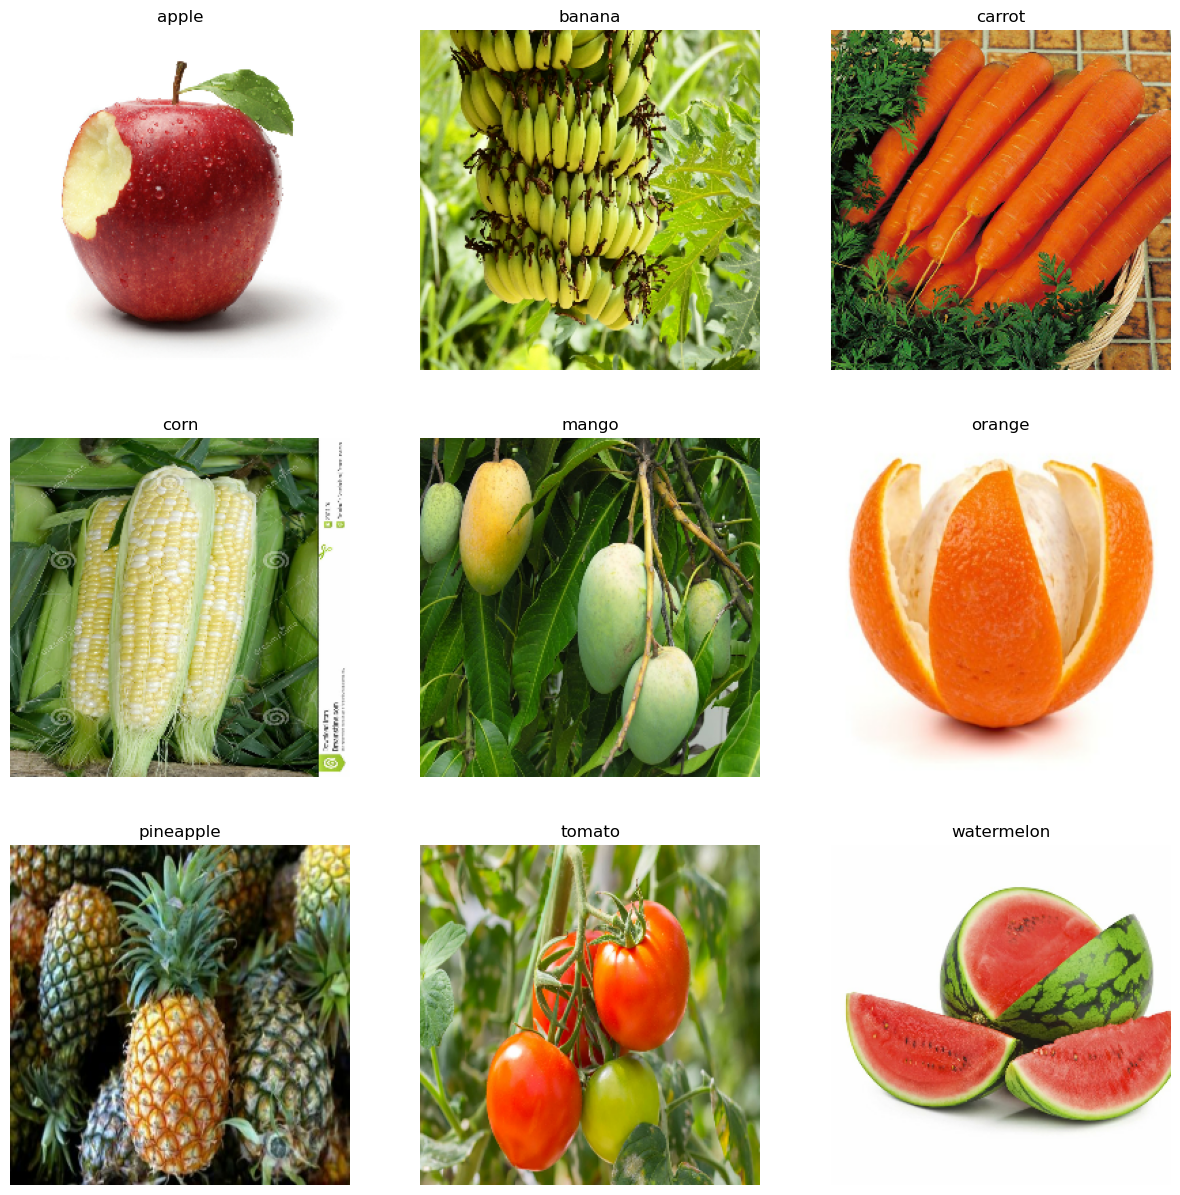

In [5]:
 class_names = train_ds.class_names
print("Class Names:", class_names)

 
images_per_class = {}
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_name not in images_per_class:
            images_per_class[class_name] = image
            
        if len(images_per_class) == len(class_names):
            break
    if len(images_per_class) == len(class_names):
        break

 
plt.figure(figsize=(15, 15))
for i, class_name in enumerate(class_names):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_per_class[class_name].numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

AUTOTUNE = tf.data.AUTOTUNE

In [6]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


In [7]:

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])



model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1

In [8]:

epochs = 17
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/17
25/25 [==============================] - 4s 147ms/step - loss: 2.5016 - accuracy: 0.2008 - val_loss: 1.7844 - val_accuracy: 0.3371
Epoch 2/17
25/25 [==============================] - 3s 102ms/step - loss: 1.6129 - accuracy: 0.4245 - val_loss: 1.1759 - val_accuracy: 0.6067
Epoch 3/17
25/25 [==============================] - 3s 105ms/step - loss: 1.3193 - accuracy: 0.5350 - val_loss: 0.8242 - val_accuracy: 0.7640
Epoch 4/17
25/25 [==============================] - 3s 106ms/step - loss: 0.9631 - accuracy: 0.6577 - val_loss: 0.6349 - val_accuracy: 0.8539
Epoch 5/17
25/25 [==============================] - 3s 106ms/step - loss: 0.7009 - accuracy: 0.7642 - val_loss: 0.3409 - val_accuracy: 0.8989
Epoch 6/17
25/25 [==============================] - 3s 106ms/step - loss: 0.5617 - accuracy: 0.8248 - val_loss: 0.3107 - val_accuracy: 0.9213
Epoch 7/17
25/25 [==============================] - 3s 114ms/step - loss: 0.3026 - accuracy: 0.9137 - val_loss: 0.3518 - val_accuracy: 0.8989
Epoch 

In [9]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

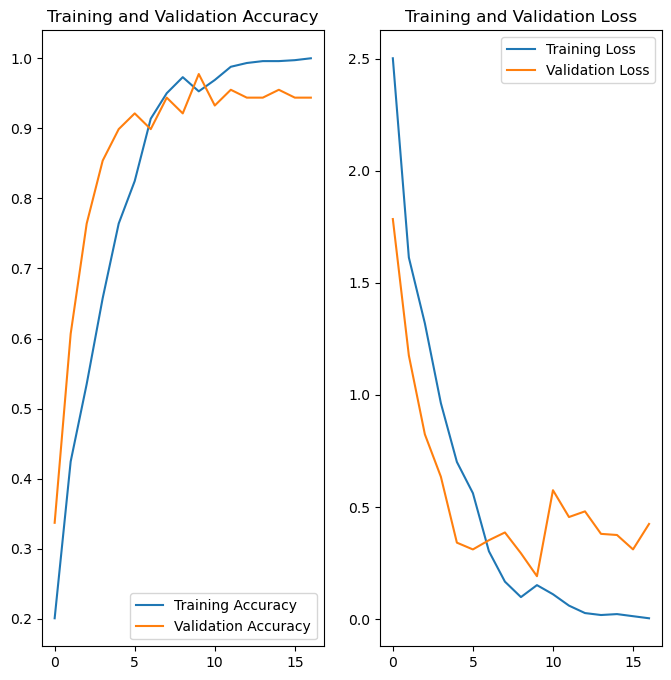

In [10]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [11]:
test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

In [12]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [13]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

3/3 [==============================] - 0s 29ms/step


In [14]:
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

print("Confusion Matrix:")
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)


Classification Report:
              precision    recall  f1-score   support

       apple       1.00      0.70      0.82        10
      banana       1.00      0.89      0.94         9
      carrot       0.82      0.90      0.86        10
        corn       1.00      1.00      1.00        10
       mango       1.00      1.00      1.00        10
      orange       1.00      1.00      1.00        10
   pineapple       0.83      1.00      0.91        10
      tomato       1.00      1.00      1.00        10
  watermelon       0.91      1.00      0.95        10

    accuracy                           0.94        89
   macro avg       0.95      0.94      0.94        89
weighted avg       0.95      0.94      0.94        89

Confusion Matrix:
[[ 7  0  2  0  0  0  0  0  1]
 [ 0  8  0  0  0  0  1  0  0]
 [ 0  0  9  0  0  0  1  0  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0 

In [15]:
accuracy = np.sum(test_labels == predicted_labels) / len(test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.9438202247191011


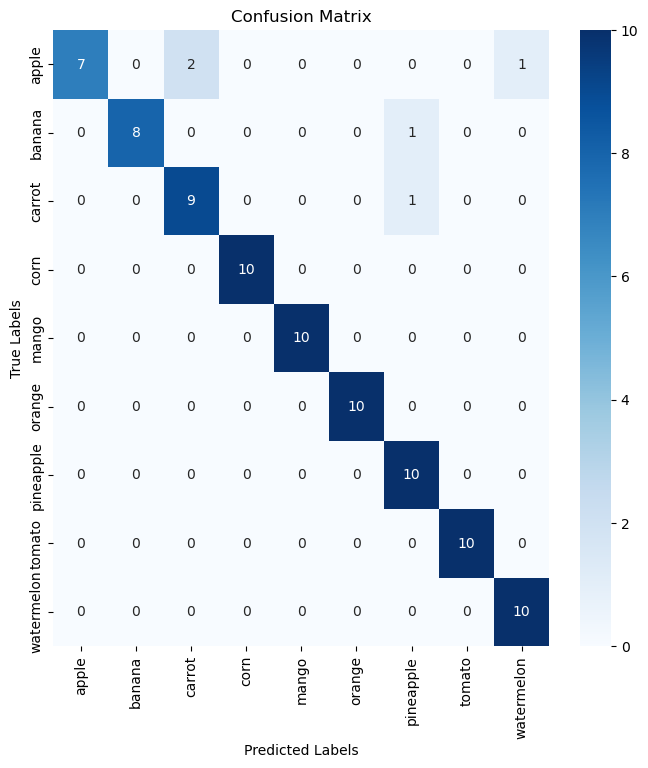

In [16]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

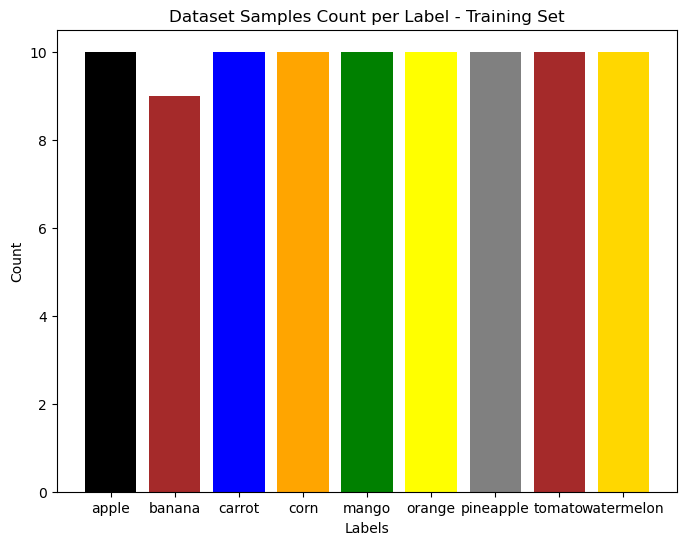

In [17]:
c = ['black', 'brown', 'blue', 'orange', 'green', 'yellow', 'grey', 'brown', 'gold']

plt.figure(figsize=(8, 6))
train_labels_count = [len(np.where(test_labels == i)[0]) for i in range(num_classes)]
plt.bar(class_names, train_labels_count, color = c)
plt.title("Dataset Samples Count per Label - Training Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

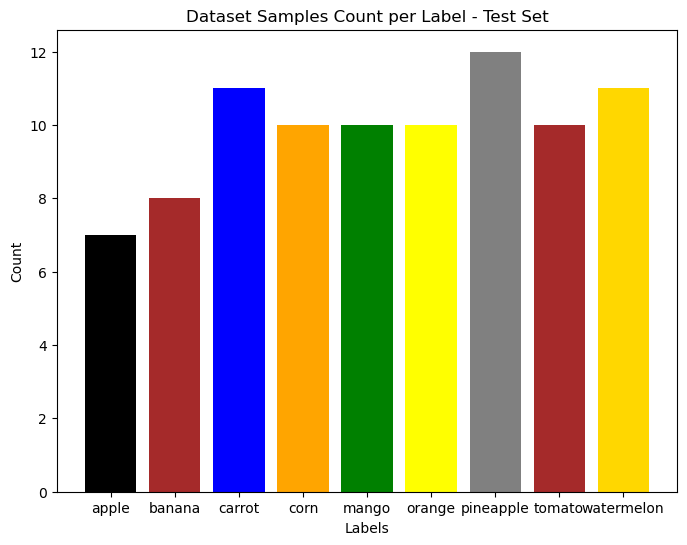

In [18]:
plt.figure(figsize=(8, 6))
test_labels_count = [len(np.where(predicted_labels == i)[0]) for i in range(num_classes)]
plt.bar(class_names, test_labels_count, color = c)
plt.title("Dataset Samples Count per Label - Test Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()